In [246]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR

import warnings
warnings.filterwarnings('ignore')

In [248]:
# df = pd.read_csv('block_0.csv')
# df = df[:505] #for household MAC000002
# df.dropna(subset=['energy_sum', 'energy_std'])
# df.shape


# df = pd.read_csv('block_48.csv')
# df = df[:829]  #for household MAC000156 (more readings than previous household)
# df.dropna(subset=['energy_sum', 'energy_std'])
# df.shape;

df = pd.read_csv('block_68.csv') # household data to be read
df = df[:820]        #for household MAC000239 
df.dropna(subset=['energy_sum', 'energy_std']) # taking the parameters
df.shape;

In [249]:
df.describe() # display the information about the data

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,820.000000,820.000000,820.000000,820.000000,819.000000,820.000000,820.000000
mean,0.118374,0.155453,0.627937,47.914634,0.117673,7.452116,0.041624
std,0.020330,0.022143,0.204982,1.783805,0.030810,1.089777,0.012381
min,0.059500,0.083000,0.083000,1.000000,0.042699,0.083000,0.015000
25%,0.105000,0.139932,0.479500,48.000000,0.094972,6.714750,0.033000
50%,0.117500,0.152906,0.604500,48.000000,0.117865,7.339000,0.040000
75%,0.130625,0.168495,0.764000,48.000000,0.136556,8.083750,0.049000
max,0.203500,0.251063,1.346000,48.000000,0.237789,12.051000,0.095000


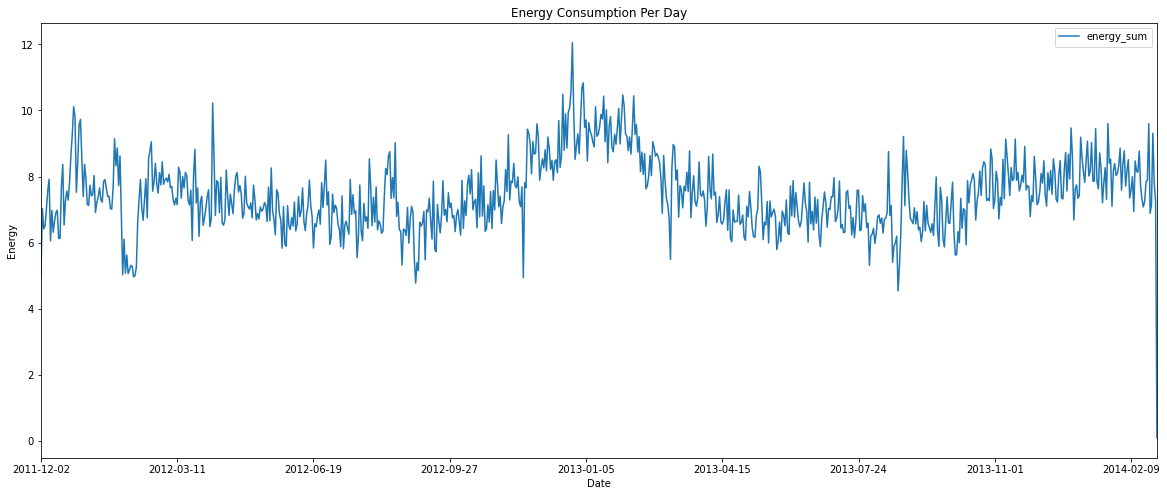

In [250]:
df.plot(x='day', y='energy_sum', figsize=(20,8), x_compat=True) # plot the engergy consumption data per day
plt.title('Energy Consumption Per Day')
plt.ylabel('Energy')
plt.xlabel('Date')
plt.show()

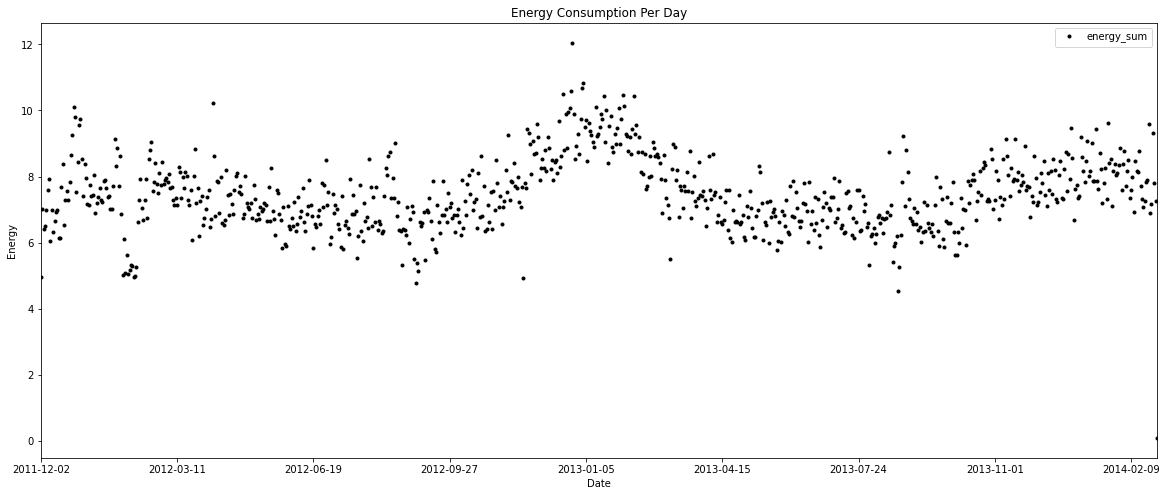

In [251]:
df.plot(x='day', y='energy_sum', figsize=(20,8), style ='k.') # plot the data as scattered dots
plt.title('Energy Consumption Per Day')
plt.ylabel('Energy')
plt.xlabel('Date')
plt.show()

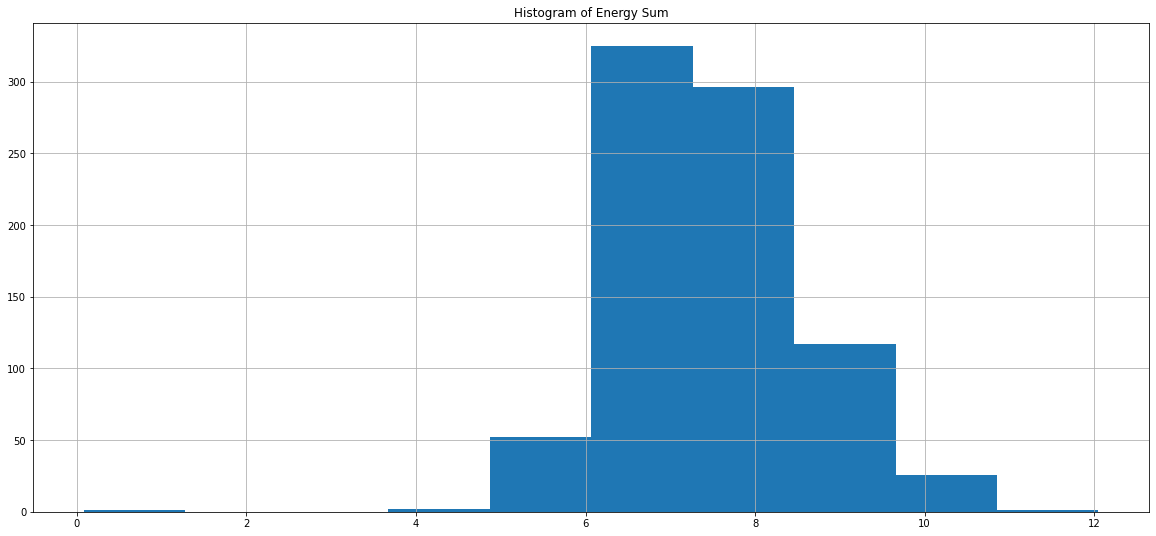

In [252]:
df['energy_sum'].hist(); # show the histogram of energy sum to see the trend of the data
plt.title('Histogram of Energy Sum')
plt.show()

In [253]:
df1 = df[['energy_sum', 'day']] # create a dataframe for energy sum and time information
df1['Datetime'] = pd.to_datetime(df['day']) # transfer the data into same format
df1 = df1.set_index('Datetime')
df1 = df1.drop(['day'], axis=1) # dispplay the data within two columns
df1

,energy_sum
Datetime,
2011-12-02,4.972
2011-12-03,7.028
2011-12-04,6.415
2011-12-05,6.511
2011-12-06,6.994
...,...
2014-02-24,7.153
2014-02-25,9.311
2014-02-26,7.801


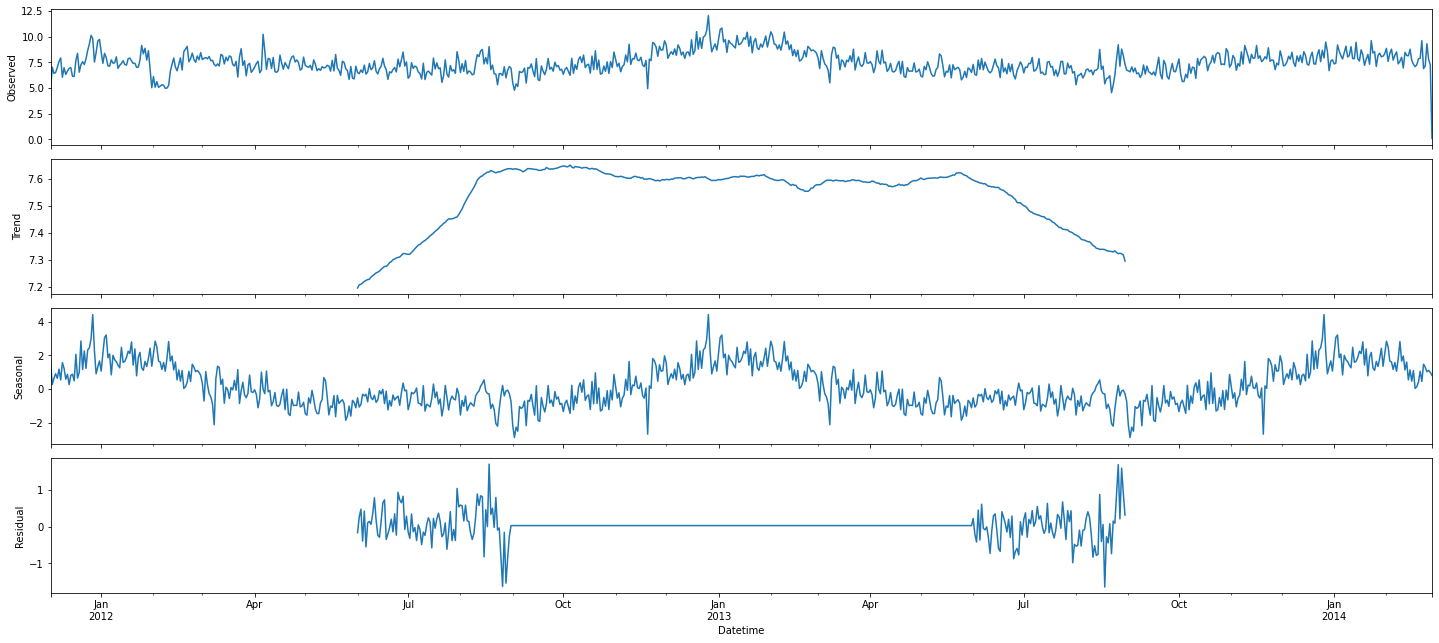

In [254]:
result = seasonal_decompose(df1, model='additive', freq=365) # show the data in a seansonal manner
result.plot() # making the plot
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

In [255]:
def testStationarity(timeseries): # analyzing the stationarity of the time series analysis
    result = adfuller(df1['energy_sum'])
    pvalue = result[1] # printing information about the stationarity
    print('ADF Statistic: ', result[0])
    print('p-value: ',  pvalue)
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if pvalue <= 0.05: # see if the series are stationary
        print('\n\n\033[1m Reject Null Hypothesis: Series is stationary')
    else:
        print('\n\033[1m Fail to reject Null Hypothesis: Series is not stationary')

In [256]:
testStationarity(df1)

ADF Statistic:  -4.090461768550885
p-value:  0.0010042880689532883
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


 Reject Null Hypothesis: Series is stationary


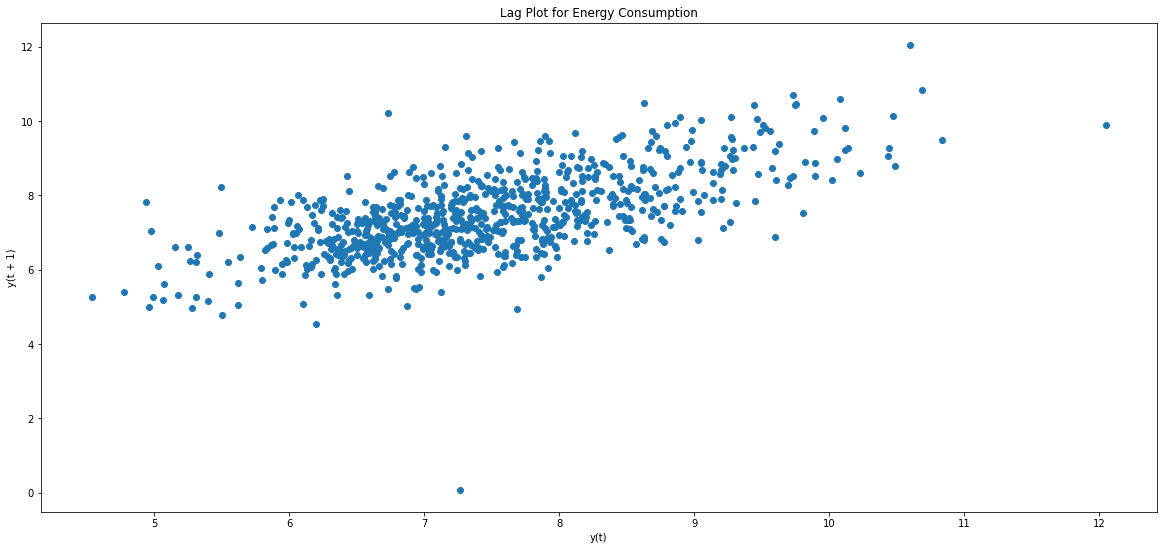

In [257]:
pd.plotting.lag_plot(df1) # the lag plot for engergy consumption
plt.title('Lag Plot for Energy Consumption')
plt.show()

In [258]:
df1_train, df1_test = train_test_split(df1, test_size = 0.2, random_state = 0) # split the data into 80% for training and 20% for testing
df1_train

,energy_sum
Datetime,
2012-01-08,7.412
2012-12-08,9.197
2012-01-19,7.639
2013-08-21,6.194
2013-12-14,8.538
...,...
2014-01-03,9.189
2012-06-11,7.654
2013-08-22,4.536


In [259]:
#autoregression model 

model = AR(df1_train) # fitting the ARIMA model with the data
fittedModel = model.fit()

print('Lag value: ', fittedModel.k_ar)

Lag value:  19


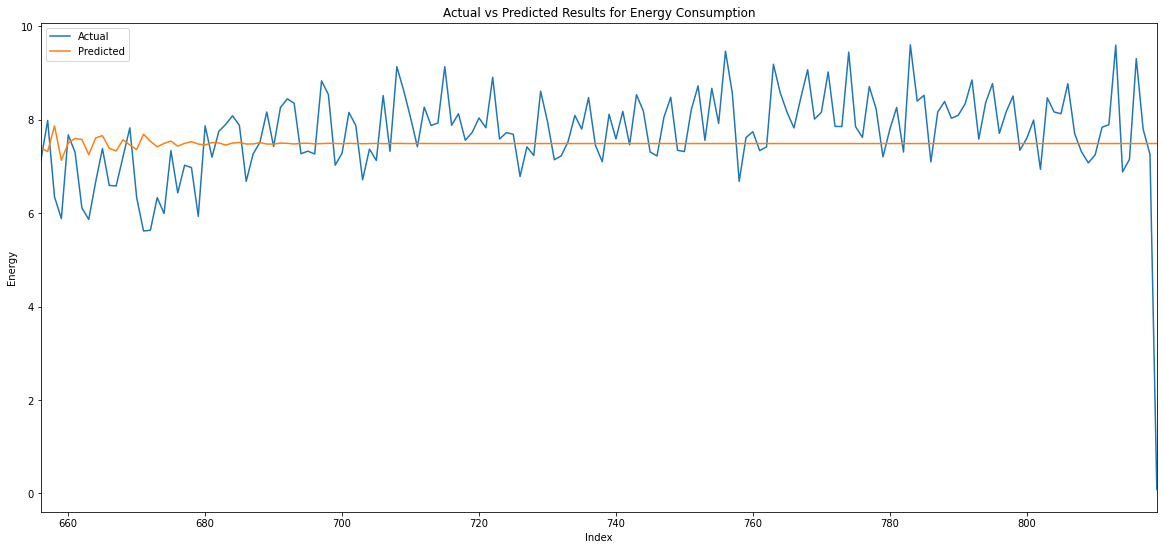

In [260]:
predictions = fittedModel.predict(start=len(df1_train), end=len(df1_train)+len(df1_test)+1, dynamic=True)
# making predictions according to the train data
comparisonDF = pd.concat([df1['energy_sum'].reset_index(), predictions], axis=1).rename(columns={'energy_sum': 'Actual', 0:'Predicted'})
comparisonDF = comparisonDF[['Actual', 'Predicted']].dropna()
# setting up two lines for actual and predicted data
comparisonDF.plot() # plot the lines to visualize the difference between the actual and predicted data
plt.title('Actual vs Predicted Results for Energy Consumption')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.show()

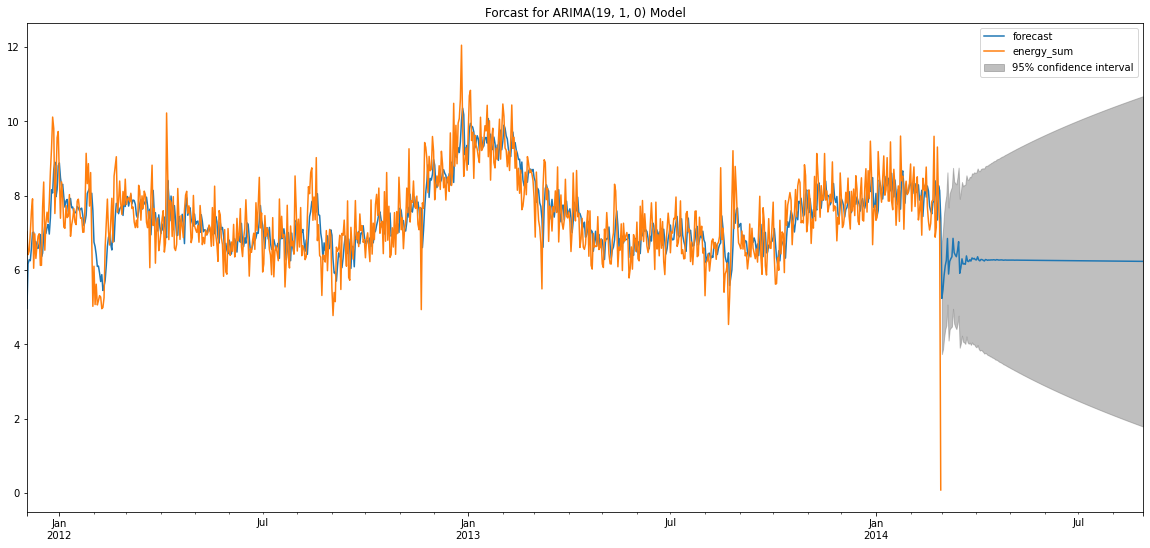

In [310]:
model = ARIMA(df1['energy_sum'], order=(19,1,0)) # changing the order for the ARIMA model to improve the result
fittedModel= model.fit()
fittedModel.plot_predict(1, 1000) #plot the forecast result for the improved ARIMA model
plt.title('Forcast for ARIMA(19, 1, 0) Model')
plt.show()